# Memetic Algorithm for VRPTW

In [82]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [83]:
#  Distance of a specific route.
def node_distance(A,B):
    return math.sqrt((A.x-B.x)**2 + (A.y-B.y)**2)
#  Calculate the distance matrix of all nodes
def distance_matrix(Nodes):
    n = len(Nodes)
    matrix = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            matrix[i][j] = node_distance(Nodes[i],Nodes[j])
    return matrix

1. Class Node, Vehicle ,Individual

In [84]:
class Node:
    def __init__(self,id,x,y,demand,Time_window,T_left,T_right,service_time):
        self.id = id
        self.x = x
        self.y = y
        self.demand = demand
        self.Time_window = Time_window # Time window in %H:%M format
        self.T_left = T_left # Time window in minutes format(H * 60 + M)
        self.T_right = T_right
        self.service_time = service_time # In minutes

class Vehicle:
    def __init__(self,depot,capacity,speed,load):
        self.depot = depot
        self.capacity = capacity
        self.speed = speed
        self.route = []
        self.load = load
        self.time = [] # The time the vehicle arrives at each node

    def add_node(self,node):
        if self.route == []:
            arrival_time = node.T_left
        else:
            arrival_time = max(self.time[-1] + self.current_node().service_time+ node_distance(self.current_node(),node) / self.speed,node.T_left)
        self.time.append(arrival_time)
        self.route.append(node)
        self.load += node.demand

    def current_node(self):
        if self.route == []:
            return self.depot
        return self.route[-1]
    
    def route_length(self):
        length = 0
        for i in range(len(self.route)-1):
            length += node_distance(self.route[i],self.route[i+1])
        return length
    
class Individual:
    def __init__(self,depot,capacity):
        self.vehicles = []
        self.depot = depot
        self.capacity = capacity

    def add_vehicle(self,vehicle):
        self.vehicles.append(vehicle)

    def encode(self):
        nodes = []
        for vehicle in self.vehicles:
            nodes += [node.id for node in vehicle.route]
        return nodes  

    def travel_distance(self):
        distance = 0
        for vehicle in self.vehicles:
            distance += vehicle.route_length()
        return distance
    
    def check_feasibility(self):
        for vehicle in self.vehicles:
            if vehicle.load > self.capacity:
                print('error')
                return False
            for i,node in enumerate(vehicle.route):
                if vehicle.time[i] > node.T_right - node.service_time:
                    print('error')
                    return False
    def cost(self):
        cost = 500 * len(self.vehicles) + self.travel_distance() # Travel distance cost
        return cost

2. Generate Nodes and Initial solution

In [85]:
def Generate_Nodes(N):
    # 1. Generate N nodes with random x,y coordinates and demand
    Nodes = []
    data = list(set((random.randrange(800), random.randrange(400),random.randrange(10,40))for _ in range(N)))
    # 2. Generate N time windows
    Time_windows = []
    T_left_list = []
    T_right_list = []
    service_times = [random.randint(10,60) for _ in range(N)]
    for _ in range(N):
        l_hour, l_minute = random.randint(8, 18), random.randint(0, 59)
        r_hour = l_hour + 2
        r_minute = random.randint(0, 59)
        l_time= f"{str(l_hour).zfill(2)}:{str(l_minute).zfill(2)}"
        r_time= f"{str(r_hour).zfill(2)}:{str(r_minute).zfill(2)}"
        Time_windows.append((l_time,r_time))
        T_left_list.append(int(l_time.split(':')[0])*60 + int(l_time.split(':')[1]))
        T_right_list.append(int(r_time.split(':')[0])*60 + int(r_time.split(':')[1]))
    # 3. Generate Nodes with time windows
    for i in range(N):
        node_i = Node(i+1,data[i][0],data[i][1],data[i][2],Time_windows[i],T_left_list[i],T_right_list[i],service_times[i])
        Nodes.append(node_i)
    return Nodes
# Generate population with k individuals
def Initial_Solution(depot,Nodes,speed,time_matrix,capacity,k):
    # 1. Generate an individual based on greedy strategy
    I = Individual(depot,capacity)
    unvisited = list(range(0,len(Nodes)))
    #Greedy strategy to select next node
    vehicle = Vehicle(depot,I.capacity,speed,0)  
    while unvisited:
        current_node = vehicle.current_node()
        # Find the next node that satisfies the capacity and time windows constraints
        next_node_set = []
        for i in unvisited:
            try :
                last_node_time = current_node.T_left # if not the first node in the vehicle route
            except:
                last_node_time = 0
            time_cons = last_node_time + current_node.service_time + time_matrix[current_node.id][Nodes[i].id] <= Nodes[i].T_right - Nodes[i].service_time
            demand_cons = vehicle.load + Nodes[i].demand <= I.capacity
            if time_cons and demand_cons:
                next_node_set.append(i) # i stands for the index of the node in unvisited list, which is the id-1 of the node
            else: continue
        # Select the closest node if next node set is not empty
        if next_node_set:
            next_node = min(next_node_set, key = lambda x: Nodes[x].T_left)
            vehicle.add_node(Nodes[next_node])
            unvisited.remove(next_node)
        else:
            I.add_vehicle(vehicle)
            vehicle = Vehicle(depot,I.capacity,speed,0)
    I.add_vehicle(vehicle)
    #generate other individuals randomly
    population = [I]
    id = list(range(1,len(Nodes)+1))
    for i in range(k-1):
        random.shuffle(id)
        I = decode(id,depot,Nodes,capacity,time_matrix,speed)
        population.append(I)
    return population    

3. Decode function that decode gene to route

In [86]:
def split(gene,depot,Nodes,capacity,time_matrix):
    n = len(gene)
    nodes = [depot] + [Nodes[i-1] for i in gene] #the index of the nodes is the same as the index of the gene
    V = [0] + [math.inf for i in range(n)] # V[i] is the minimum travel time to visit nodes[i] in axuiliary route
    P = [0] * (n+1) #P_j is the predecessor of j on the path
    for i in range(1,n+1):
        load, time_cost, j = 0, 0, i
        while j <= n:
            load += nodes[j].demand
            if j == i:
                time_cost = time_matrix[0][nodes[j].id] * 2 + nodes[j].service_time
            else:
                time_delay = max(0,nodes[j-1].T_left + nodes[j-1].service_time + time_matrix[nodes[j-1].id][nodes[j].id] - nodes[j].T_right + nodes[j].service_time)
                if time_delay > 0: # cost punishment for violating time window
                    break
                time_cost += time_matrix[nodes[j-1].id][nodes[j].id] + nodes[j].service_time + time_matrix[nodes[j].id][0] - time_matrix[nodes[j-1].id][0]
            if load <= capacity:# and time_cost < beta:
                if V[i-1] + time_cost < V[j]:
                    V[j] = V[i-1] + time_cost
                    P[j] = i-1
                j += 1        
            else:
                break           
    return V,P

def gene_to_Individual(P,gene,depot,Nodes,capacity,speed):
    nodes = [depot] + [Nodes[i-1] for i in gene]
    n = len(gene) # number of nodes excluding depot
    I = Individual(depot,capacity)
    j = n # j is the last node in a route
    while j > 0:
        vehicle = Vehicle(depot,capacity,speed,0)
        i = P[j] # i is the predecessor of j, which is the first node in the route
        for k in range(i+1,j+1):
            vehicle.add_node(nodes[k])
        I.add_vehicle(vehicle)
        j = i
    return I

def decode(gene,depot,Nodes,capacity,time_matrix,speed):
    V,P = split(gene,depot,Nodes,capacity,time_matrix)
    I = gene_to_Individual(P,gene,depot,Nodes,capacity,speed)
    return I

4. Crossover, Mutation, Local search and plot function

In [87]:
def ordered_crossover(population):
    I1,I2 = tournament_selection(population,len(population)//2,2)
    ind1,ind2 = I1.encode().copy(), I2.encode().copy()
    i,j = sorted(random.sample(range(len(ind1)-1),2))
    X_segment = ind1[i:j+1]
    Y_segment = [i for i in ind2 if i not in X_segment]
    offspring = Y_segment[:i] + X_segment + Y_segment[i:]
    return offspring

def mutation(I):
    gene = I.encode()
    i,j = random.sample(range(len(gene)),2)
    gene[i],gene[j] = gene[j],gene[i]
    offspring = gene
    return offspring

def tournament_selection(population,tournament_size,k):
    fitness = [(i,1/individual.travel_distance()) for i,individual in enumerate(population)]
    winner = []
    for i in range(k):
        participents = random.sample(fitness,tournament_size)
        selected = max(participents, key = lambda x: x[1])[0]
        winner.append(selected)
    selected_individuals = [population[i] for i in winner]
    return selected_individuals

def local_search(I):
    return I

def plot_route(I):
    depot = I.depot
    plt.plot(depot.x,depot.y,'bs',markersize=10,label = 'Depot')
    #plt.text(depot.x, depot.y, 'Depot', fontsize=12, ha='right')
    for vehicle in I.vehicles:
        for node in vehicle.route:
            plt.plot(node.x,node.y)
            plt.text(node.x, node.y, '{}'.format(node.id), fontsize=10, ha='right')
        x = [depot.x] + [node.x for node in vehicle.route] + [depot.x]
        y = [depot.y] + [node.y for node in vehicle.route] + [depot.y]
        plt.plot(x,y)
    plt.legend()
    plt.show()
    return

5. Main Function

best solution cost: 4802.139094885907 Travel distance: 1302.1390948859073


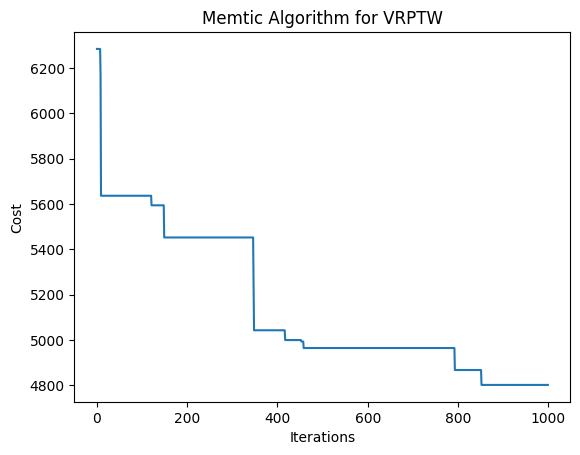

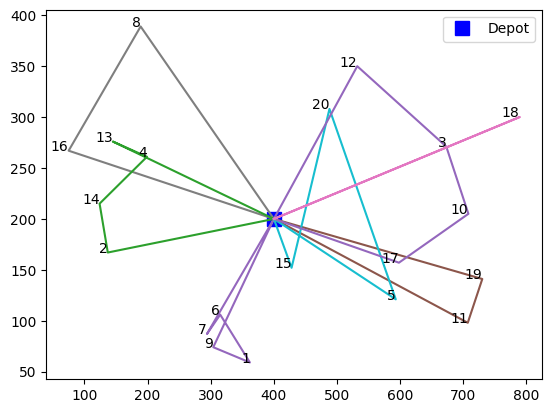

In [88]:
#1. Initialize the depot, nodes and parameters
nodes = Generate_Nodes(20)#sorted(Generate_Nodes(20), key = lambda x: x.T_left)
depot = Node(0,400,200,0,("00:00","24:00"),0*60,24*60,0)
capacity = 200
speed = 10
k = 100
distance_Matrix = np.array(distance_matrix([depot] + nodes))
travel_time_Marix = np.array(distance_Matrix) / speed
epochs = 1000
#2. Genrate initial solution
population = Initial_Solution(depot,nodes,speed,travel_time_Marix,capacity,k)
iterations = []
best_sol = min(population, key = lambda x: x.cost())
ind = population[1]
#3. Evolution
for ep in range(epochs):
    # crossover 
    gene = ordered_crossover(population)
    offspring = decode(gene,depot,nodes,capacity,travel_time_Marix,speed)
    population.append(offspring)
    population = sorted(population, key = lambda x: x.cost())[:k]
    # mutation
    if random.random() < 0.1:
        j = random.randint(0,len(population)-1)
        gene = mutation(population[j])
        population[j] = decode(gene,depot,nodes,capacity,travel_time_Marix,speed)
    # do local search
    ind = min(population, key = lambda x: x.cost())

    if ind.cost() < best_sol.cost():
        best_sol = ind
    iterations.append(best_sol.cost())

#4. Visualization
print('best solution cost:',best_sol.cost(), 'Travel distance:',best_sol.travel_distance())
plt.plot(iterations)
plt.title('Memtic Algorithm for VRPTW')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()
plot_route(best_sol)

References:  
[1]	"[A simple and effective evolutionary algorithm for the vehicle routing problem](https://www.webofscience.com/wos/alldb/full-record/WOS:000222247600003)," Comput. Oper. Res., vol. 31, no. 12, 2004/10/01, doi: 10.1016/S0305-0548(03)00158-8.